In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from model import *
from helpers import *
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import os 
import re
import glob

In [ ]:
num = -6.5
mu = mu_p = num
width = 50
learning_rate = 1e-3
x_data,y_data,dataset_name=generate_3D_input_dataset()
beta_1, beta_2 = cal_betas(mu,mu_p, width)
print(beta_1, beta_2) # these are the std
savefolder = dataset_name 
torch.backends.cudnn.deterministic = True
random_seed = 12
config = f"{mu:.3f}_{mu_p:.3f}_w{width}_rs{random_seed}"
operation_step_gap = 2000
loss_print_step = operation_step_gap
loss_update_step = operation_step_gap
weight_record_step = operation_step_gap
output_plot_step =  operation_step_gap
weight_savedir = "weight_recording"
error_savedir = "error_recording"
loss_savedir = "loss_recording"
parse_iter_id = -1
pic_savedir = 'pics'
training_iters = 8e5

9.050966799187808e-12 9.050966799187808e-12


Training

In [3]:
print(savefolder)
net = two_layer_net(3,width,1,beta_1, beta_2, random_seed=random_seed, )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train(net, x_data, y_data, learning_rate, stopping_loss = 1e-5, max_iter = training_iters,
        config = config, weight_savedir=weight_savedir,
        loss_pic_savedir=pic_savedir, loss_print_step= loss_print_step, weight_record_step=weight_record_step, savefolder = savefolder,\
        loss_update_step=loss_update_step, loss_display_lim = 1.5, loss_logscale = True)

3D_input_1D_output

-6.500_-6.500_w50_rs12
training


100%|██████████| 800000/800000.0 [08:07<00:00, 1639.69it/s]


<Figure size 600x400 with 0 Axes>

Reproducing Figure 11

In [ ]:
weight_wholedir = os.path.join(savefolder, config, weight_savedir)
input_weights_paths = glob.glob(os.path.join(weight_wholedir,"*input.pt"))
output_weights_paths = glob.glob(os.path.join(weight_wholedir,"*output.pt"))
def return_num_in_str(string, parse_num_id = parse_iter_id):
    return int(re.findall(r'\d+', string)[parse_num_id])
input_weights_paths = sorted(input_weights_paths, key = return_num_in_str)
output_weights_paths = sorted(output_weights_paths, key = return_num_in_str)
assert len(input_weights_paths)!=0
error_wholedir= os.path.join(savefolder, config, error_savedir)
errors_paths = glob.glob(os.path.join(error_wholedir,"*.pt"))
errors_paths = sorted(errors_paths, key = return_num_in_str)

# collecting all the information for plotting
all_steps_dataframe = pd.DataFrame()
for input_weights_path, output_weights_path, errors_path in tqdm(zip(input_weights_paths, output_weights_paths, errors_paths),total = len(input_weights_paths)):
    iter_num = re.findall(r'\d+', input_weights_path)[-1]
    input_weight = torch.load(input_weights_path,map_location = device)
    output_weight = torch.load(output_weights_path, map_location = device).t()
    input_size, output_size = (input_weight.shape, output_weight.shape)
    error = torch.load(errors_path, map_location = device)

    # find out which hidden neurons are connected to zero input and output weights
    input_weight_zero_pos = (input_weight == torch.zeros(input_size)).any(axis = 1)
    output_weight_zero_pos = (output_weight == torch.zeros(output_size)).any(axis = 1)
    overall_zero_pos = torch.logical_and(input_weight_zero_pos, output_weight_zero_pos) ## only weights with zero input and output weight at initialization time is guaranteed to have no effect on the system.
    nonzero_input_weight = input_weight[~overall_zero_pos]
    nonzero_output_weight = output_weight[~overall_zero_pos]
    nonzero_input_weight_ls = [tensor for tensor in nonzero_input_weight]
    nonzero_output_weight_ls = [tensor for tensor in nonzero_output_weight]
    nonzero_input_weight_id = (~overall_zero_pos).nonzero().squeeze(1)
    
    input_weight_norm = torch.linalg.norm(nonzero_input_weight, dim = 1) 
    
    input_weight_angle = np.arctan2(nonzero_input_weight[:,1], nonzero_input_weight[:,0])# only studying the first two component angle.
    input_weight_angle = to_right_range(input_weight_angle)

    one_step_dataframe = pd.DataFrame(
        {   "iteration":[iter_num]*nonzero_input_weight_id.shape[0],
            "weight_id":nonzero_input_weight_id,
            "input_weight": nonzero_input_weight_ls,
            "output_weight": nonzero_output_weight_ls,
            "input_weight_angle": input_weight_angle,
            "input_weight_norm": input_weight_norm,
            "error": [error]* nonzero_input_weight_id.shape[0]
        })
    
    all_steps_dataframe = pd.concat([all_steps_dataframe,one_step_dataframe],ignore_index=True)

all_steps_dataframe["weight_id"] = all_steps_dataframe["weight_id"].astype(str) ## better for visualization

# figure out the coloring of the curves based on the final angles
all_steps_dataframe_new = all_steps_dataframe.copy()
all_steps_dataframe_new["iteration_num"] = all_steps_dataframe_new["iteration"].astype(int)
angle_time_df = all_steps_dataframe_new.pivot(index="iteration_num",columns="weight_id",values="input_weight_angle")
iter_array = angle_time_df.index.values
final_angle = angle_time_df.iloc[-1]
group1_condition = (final_angle>=2.4)&(final_angle<2.5)  
group1_id_ls = np.asarray(final_angle[group1_condition].index,dtype = 'int')
group2_condition = (final_angle>=1.9)&(final_angle<2.4)
group2_id_ls = np.asarray(final_angle[group2_condition].index,dtype = 'int')
group3_condition =  (final_angle<1.9)
group3_id_ls = np.asarray(final_angle[group3_condition].index,dtype = 'int')
group4_condition = (final_angle>=2.5) & (final_angle<3)
group4_id_ls = np.asarray(final_angle[group4_condition].index,dtype = 'int')
group5_condition = (final_angle>=3)
group5_id_ls = np.asarray(final_angle[group5_condition].index,dtype = 'int')
def get_color(id):
    if id in group1_id_ls: return 'c'
    if id in group2_id_ls: return 'y'
    if id in group3_id_ls: return 'g'
    if id in group4_id_ls: return 'b'
    if id in group5_id_ls: return 'r'

# the following steps will be marked with dotted lines
critical_step_ls = np.array([0.8,1.2,1.7,3.3])*1e5

100%|██████████| 400/400 [00:13<00:00, 30.58it/s]


C:\Users\Zhengqing\AppData\Local\Temp\ipykernel_16156\1929143759.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticks(),  )
C:\Users\Zhengqing\AppData\Local\Temp\ipykernel_16156\1929143759.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_yticklabels(axs[2].get_yticks(),  )


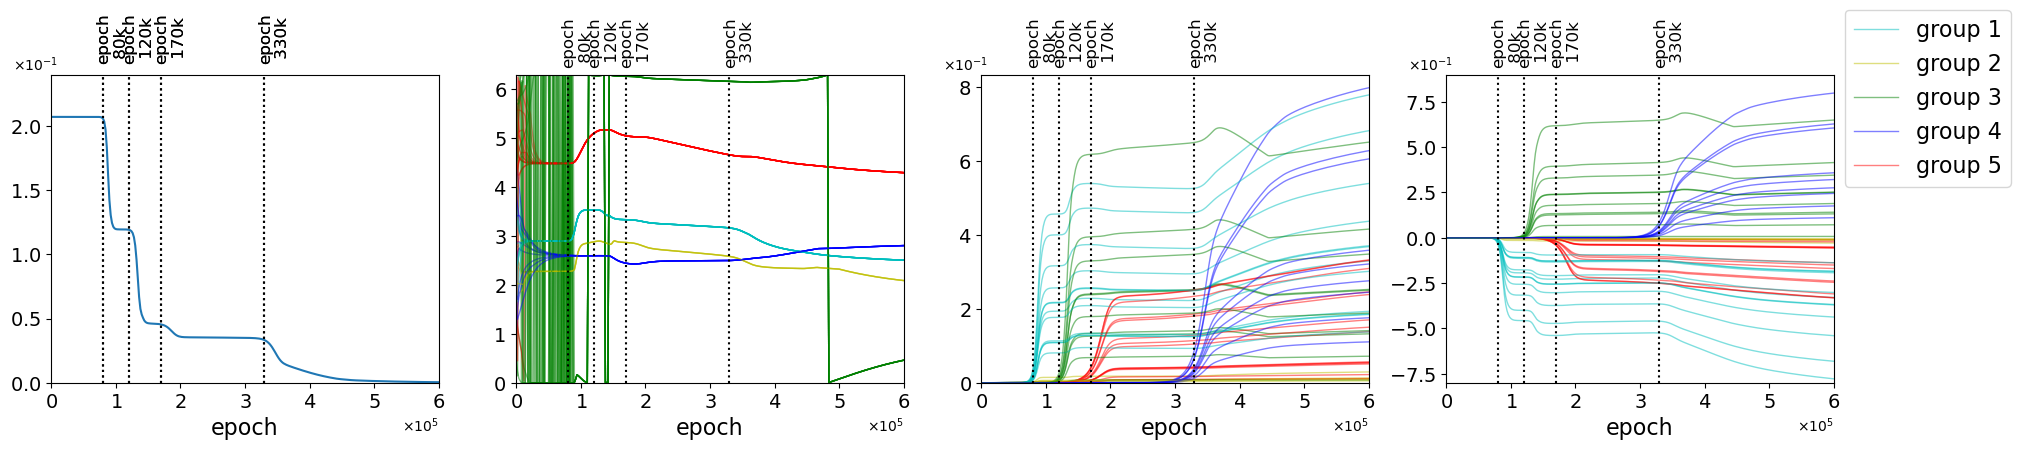

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(23, 4))  # 1 row, 4 columns
labelsize = 16
textsize = 12
ticksize = 14
xlim_max = 6e5
order = [2,3,1,4,0]

# The loss plot
loss_dir = os.path.join(savefolder, config, loss_savedir, "loss.npz")
data = np.load(loss_dir)
loss_arr = data['loss_arr']
iter_arr = data['iter_arr']
axs[0].plot(iter_arr[1:], loss_arr[1:])
vertical_line(axs[0], critical_step_ls, textsize, height=50/44)
axs[0].set_xlabel("epoch", fontsize=labelsize)
axs[0].xaxis.set_major_formatter(formatter1)
axs[0].set_yticklabels(axs[0].get_yticks(),  ) 
axs[0].yaxis.set_major_formatter(formatter)
ylim_max = 0.24
vertical_line(axs[0], critical_step_ls, textsize, height=50/44)
axs[0].set_ylim([0, ylim_max])
axs[0].set_xlim([0, xlim_max])
axs[0].yaxis.get_offset_text().set_x(-0.1)
axs[0].tick_params(axis='both', which='major', labelsize=ticksize)

# Plot data on each subplot
# we only need one legend for one group, groupx_ready is just a technical artifact to achieve that.
group1_already = False
group2_already = False
group3_already = False
group4_already = False
group5_already = False
line_style = "-"
for i in range(50):
    plot_data = angle_time_df[str(i)].values
    color = get_color(i)
    alpha = .5 
    linewidth = 1
    if color == 'c' and not group1_already:
        axs[1].plot(iter_array, plot_data, color+line_style, linewidth=linewidth, alpha=alpha, label="group 1")
        group1_already = True
    elif color == 'y' and not group2_already:
        axs[1].plot(iter_array, plot_data, color+line_style, linewidth=linewidth, alpha=alpha, label="group 2")
        group2_already = True
    elif color == 'g' and not group3_already:
        axs[1].plot(iter_array, plot_data, color+line_style, linewidth=linewidth, alpha=alpha, label="group 3")
        group3_already = True
    elif color == 'b' and not group4_already:
        axs[1].plot(iter_array, plot_data, color+line_style, linewidth=linewidth, alpha=alpha, label="group 4")
        group4_already = True
    elif color == 'r' and not group5_already:
        axs[1].plot(iter_array, plot_data, color+line_style, linewidth=linewidth, alpha=alpha, label="group 5")
        group5_already = True
    else:
        axs[1].plot(iter_array, plot_data, color+line_style, linewidth=linewidth, alpha=alpha)
axs[1].set_xlabel('epoch', fontsize=labelsize)
axs[1].xaxis.set_major_formatter(formatter1)
ylim_max = 2 * np.pi
axs[1].set_ylim([0, ylim_max])
axs[1].set_xlim([0, xlim_max])
vertical_line(axs[1], critical_step_ls, textsize)
axs[1].tick_params(axis='both', which='major', labelsize=ticksize)

# Input norm plot
input_norm_time_df = all_steps_dataframe_new.pivot(index="iteration_num", columns="weight_id", values="input_weight_norm")
group1_already = False
group2_already = False
group3_already = False
group4_already = False
group5_already = False
line_style = "-"
for i in range(50):
    plot_data = input_norm_time_df[str(i)].values
    color = get_color(i)
    alpha = .5 
    linewidth = 1
    if color == 'c' and not group1_already:
        axs[2].plot(iter_array, plot_data, color+line_style, linewidth=linewidth, alpha=alpha, label="group 1")
        group1_already = True
    elif color == 'y' and not group2_already:
        axs[2].plot(iter_array, plot_data, color+line_style, linewidth=linewidth, alpha=alpha, label="group 2")
        group2_already = True
    elif color == 'g' and not group3_already:
        axs[2].plot(iter_array, plot_data, color+line_style, linewidth=linewidth, alpha=alpha, label="group 3")
        group3_already = True
    elif color == 'b' and not group4_already:
        axs[2].plot(iter_array, plot_data, color+line_style, linewidth=linewidth, alpha=alpha, label="group 4")
        group4_already = True
    elif color == 'r' and not group5_already:
        axs[2].plot(iter_array, plot_data, color+line_style, linewidth=linewidth, alpha=alpha, label="group 5")
        group5_already = True
    else:
        axs[2].plot(iter_array, plot_data, color+line_style, linewidth=linewidth, alpha=alpha)
axs[2].set_xlabel('epoch', fontsize=labelsize)
axs[2].xaxis.set_major_formatter(formatter1)
axs[2].set_yticklabels(axs[2].get_yticks(),  ) 
axs[2].yaxis.set_major_formatter(formatter)
axs[2].yaxis.get_offset_text().set_x(-0.1)
handles, labels = axs[2].get_legend_handles_labels()
ylim_max = 0.834
axs[2].set_ylim([0, ylim_max])
axs[2].set_xlim([0, xlim_max])
vertical_line(axs[2], critical_step_ls, textsize)
axs[2].tick_params(axis='both', which='major', labelsize=ticksize)

# Output weight plot
output_weight_time_df = all_steps_dataframe_new.pivot(index="iteration_num", columns="weight_id", values="output_weight")
group1_already = False
group2_already = False
group3_already = False
group4_already = False
group5_already = False
line_style = "-"
for i in range(50):
    plot_data = output_weight_time_df[str(i)].values
    color = get_color(i)
    alpha = .5 
    linewidth = 1
    if color == 'c' and not group1_already:
        axs[3].plot(iter_array, plot_data, color+line_style, linewidth=linewidth, alpha=alpha, label="group 1")
        group1_already = True
    elif color == 'y' and not group2_already:
        axs[3].plot(iter_array, plot_data, color+line_style, linewidth=linewidth, alpha=alpha, label="group 2")
        group2_already = True
    elif color == 'g' and not group3_already:
        axs[3].plot(iter_array, plot_data, color+line_style, linewidth=linewidth, alpha=alpha, label="group 3")
        group3_already = True
    elif color == 'b' and not group4_already:
        axs[3].plot(iter_array, plot_data, color+line_style, linewidth=linewidth, alpha=alpha, label="group 4")
        group4_already = True
    elif color == 'r' and not group5_already:
        axs[3].plot(iter_array, plot_data, color+line_style, linewidth=linewidth, alpha=alpha, label="group 5")
        group5_already = True
    else:
        axs[3].plot(iter_array, plot_data, color+line_style, linewidth=linewidth, alpha=alpha)
axs[3].set_xlabel('epoch', fontsize=labelsize)
handles, labels = axs[3].get_legend_handles_labels()
axs[3].xaxis.set_major_formatter(formatter1)
axs[3].yaxis.set_major_formatter(formatter)
axs[3].yaxis.get_offset_text().set_x(-0.1)
ylim_min = -0.8
ylim_max = 0.9
axs[3].set_ylim([ylim_min, ylim_max])
axs[3].set_xlim([0, xlim_max])
vertical_line(axs[3], critical_step_ls, textsize)
axs[3].tick_params(axis='both', which='major', labelsize=ticksize)
axs[3].legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=labelsize, bbox_to_anchor=(1., 0.6))
plt.savefig(os.path.join(savefolder,config,"all_in_one_plot.png"), bbox_inches='tight',dpi=300)


There is no need to numerically verify whether GD ends up in a local minimum, since zero loss is acheived.